<a href="https://colab.research.google.com/github/spencer18001/ml_zoomcamp_project_2024_midterm/blob/main/Notebook/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install tqdm xgboost
!wget -O player_statistics_cleaned_final.csv https://raw.githubusercontent.com/spencer18001/ml_zoomcamp_project_2024_midterm/refs/heads/main/Data/player_statistics_cleaned_final.csv

In [2]:
import math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from tqdm.auto import tqdm
import xgboost as xgb

sns.set_theme()

## EDA

### Data Cleaning

In [3]:
df_path = "player_statistics_cleaned_final.csv"
df = pd.read_csv(df_path)
df

,TeamName,PlayerName,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSPerMin,...,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills,Country,FlashKeybind
0,Top Esports,369,Top,8,0.500,3.1,2.5,2.4,4.9,7.6,...,0.13,322,5,424,0.000,0.250,0,2,China,D
1,Dplus KIA,aiming,Adc,9,0.333,4.8,5.0,2.0,4.7,10.1,...,0.10,-112,1,97,0.333,0.000,0,2,South Korea,F
2,MAD Lions KOI,alvaro,Support,5,0.200,1.5,0.2,4.4,6.2,1.2,...,0.49,-3,2,-256,0.000,0.600,0,-,Spain,D
3,Team Liquid,apa,Mid,10,0.500,2.4,3.5,3.2,4.2,8.7,...,0.18,278,2,216,0.400,0.000,0,3,United States,D
4,PSG Talon,azhi,Top,5,0.200,2.3,2.2,3.0,4.8,7.5,...,0.18,-311,-10,-168,0.200,0.000,0,-,Taiwan,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Team Liquid,yeon,Adc,10,0.500,4.9,3.8,1.8,5.0,10.0,...,0.16,224,6,571,0.500,0.000,0,-,United States,D
77,G2 Esports,yike,Jungle,8,0.375,4.5,3.1,2.4,7.6,6.4,...,0.22,102,4,-80,0.250,0.000,0,2,Sweden,D
78,Hanwha Life Esports,zeka,Mid,12,0.500,3.6,3.8,2.8,6.2,9.1,...,0.24,288,2,66,0.250,0.167,0,1,South Korea,F
79,T1,zeus,Top,8,0.875,7.1,3.9,1.6,7.6,7.9,...,0.19,633,8,370,0.125,0.000,0,2,South Korea,F


In [4]:
target_name = "Win rate"

In [5]:
# exclude these features
df.drop(columns=["TeamName", "PlayerName", "Country"], inplace=True)

In [6]:
# missing value
df.isnull().sum()

,0
Position,0
Games,0
Win rate,0
KDA,0
Avg kills,0
Avg deaths,0
Avg assists,0
CSPerMin,0
GoldPerMin,0
KP%,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Position       81 non-null     object 
 1   Games          81 non-null     int64  
 2   Win rate       81 non-null     float64
 3   KDA            81 non-null     float64
 4   Avg kills      81 non-null     float64
 5   Avg deaths     81 non-null     float64
 6   Avg assists    81 non-null     float64
 7   CSPerMin       81 non-null     float64
 8   GoldPerMin     81 non-null     int64  
 9   KP%            81 non-null     float64
 10  DamagePercent  81 non-null     float64
 11  DPM            81 non-null     int64  
 12  VSPM           81 non-null     float64
 13  Avg WPM        81 non-null     float64
 14  Avg WCPM       81 non-null     float64
 15  Avg VWPM       81 non-null     float64
 16  GD@15          81 non-null     int64  
 17  CSD@15         81 non-null     int64  
 18  XPD@15      

In [8]:
for c in df.dtypes[df.dtypes == "object"].index:
    print(f"{df[c].value_counts().head(8)}\n")

Position
Jungle     17
Top        16
Adc        16
Support    16
Mid        16
Name: count, dtype: int64

Solo Kills
-    38
1    18
2    16
3     6
4     1
6     1
5     1
Name: count, dtype: int64

FlashKeybind
D    44
F    37
Name: count, dtype: int64



In [9]:
# "Solo Kills" should be a numerical feature
# based on dataset documentation, "-" likely indicates 0
df["Solo Kills"] = df["Solo Kills"].replace(to_replace="-", value=0)
df["Solo Kills"] = df["Solo Kills"].astype(int)
df["Solo Kills"].dtype

dtype('int64')

### Analysis of Numerical Feature

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Games,81.0,8.641975,2.908215,3.000,6.000,8.000,10.000,14.000
Win rate,81.0,0.455975,0.214833,0.000,0.333,0.500,0.615,0.875
KDA,81.0,3.765432,1.834677,1.200,2.400,3.400,4.400,9.300
Avg kills,81.0,2.686420,1.519355,0.200,1.200,2.500,3.900,5.600
Avg deaths,81.0,2.875309,0.896734,1.300,2.400,2.900,3.300,5.600
Avg assists,81.0,6.755556,2.390293,1.800,4.900,6.200,8.300,12.400
CSPerMin,81.0,6.656790,3.048850,1.000,5.700,7.900,8.900,10.500
GoldPerMin,81.0,362.654321,72.095797,225.000,320.000,385.000,416.000,486.000
KP%,81.0,0.680790,0.088962,0.410,0.623,0.691,0.751,0.849
DamagePercent,81.0,0.199605,0.084498,0.052,0.135,0.215,0.275,0.337


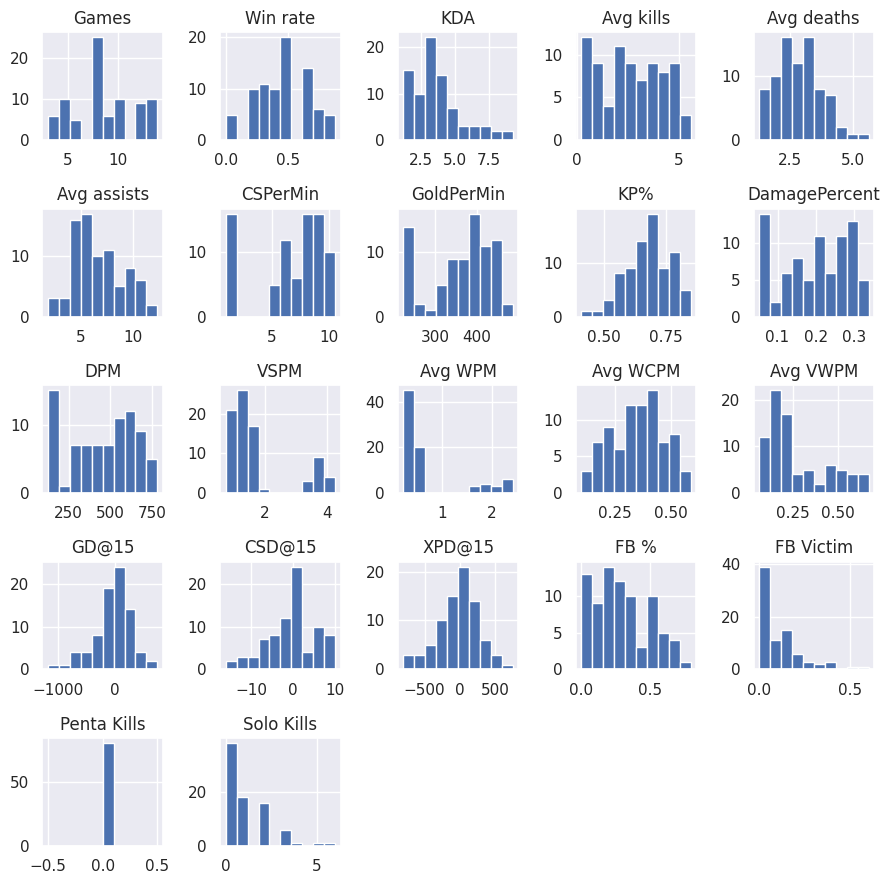

In [11]:
df.hist(figsize=(9,9))
plt.tight_layout()

In [12]:
# remove "Penta Kills" as all values are 0
df.drop(columns=["Penta Kills"], inplace=True)

In [13]:
df_corr = df.drop(columns=[target_name]).corr(numeric_only=True)
df_corr

,Games,KDA,Avg kills,Avg deaths,Avg assists,CSPerMin,GoldPerMin,KP%,DamagePercent,DPM,VSPM,Avg WPM,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Solo Kills
Games,1.000000,0.317904,0.180504,-0.283830,0.245471,0.024878,0.119293,0.135954,0.014728,0.077452,0.061127,0.027217,0.069665,-0.031256,0.340724,0.217146,0.178464,-0.045178,0.044663,0.117988
KDA,0.317904,1.000000,0.497134,-0.832862,0.271199,0.281098,0.421084,0.429310,0.272719,0.339918,-0.135625,-0.171814,0.049486,-0.219322,0.398847,0.248479,0.226160,0.114186,-0.190786,-0.026025
Avg kills,0.180504,0.497134,1.000000,-0.622103,-0.522891,0.853905,0.928575,-0.057285,0.873159,0.896552,-0.703989,-0.668019,-0.429822,-0.785483,0.231283,0.126321,0.083008,-0.189543,-0.306373,0.383996
Avg deaths,-0.283830,-0.832862,-0.622103,1.000000,0.087657,-0.498930,-0.581410,-0.166988,-0.478867,-0.518672,0.388517,0.390030,0.222824,0.489942,-0.228040,-0.206817,-0.219374,0.025732,0.326384,-0.128416
Avg assists,0.245471,0.271199,-0.522891,0.087657,1.000000,-0.675742,-0.589098,0.643119,-0.678297,-0.610840,0.670828,0.569139,0.602371,0.686787,0.322745,0.189499,0.197615,0.470336,0.061705,-0.417274
CSPerMin,0.024878,0.281098,0.853905,-0.498930,-0.675742,1.000000,0.971359,-0.267449,0.940056,0.930192,-0.930109,-0.900350,-0.580300,-0.923830,-0.001789,-0.005810,-0.000431,-0.319499,-0.234413,0.387361
GoldPerMin,0.119293,0.421084,0.928575,-0.581410,-0.589098,0.971359,1.000000,-0.183706,0.940727,0.951916,-0.855359,-0.824891,-0.526291,-0.891803,0.148138,0.071921,0.075390,-0.275687,-0.266298,0.402608
KP%,0.135954,0.429310,-0.057285,-0.166988,0.643119,-0.267449,-0.183706,1.000000,-0.215266,-0.186297,0.364714,0.252839,0.553802,0.309200,0.299056,0.243899,0.218915,0.503187,-0.248975,-0.350932
DamagePercent,0.014728,0.272719,0.873159,-0.478867,-0.678297,0.940056,0.940727,-0.215266,1.000000,0.984755,-0.809300,-0.751566,-0.526203,-0.858017,0.041379,0.016435,0.037986,-0.302447,-0.260293,0.444007
DPM,0.077452,0.339918,0.896552,-0.518672,-0.610840,0.930192,0.951916,-0.186297,0.984755,1.000000,-0.794703,-0.745905,-0.506598,-0.849567,0.120580,0.053146,0.089382,-0.262613,-0.262563,0.442517


<Axes: >

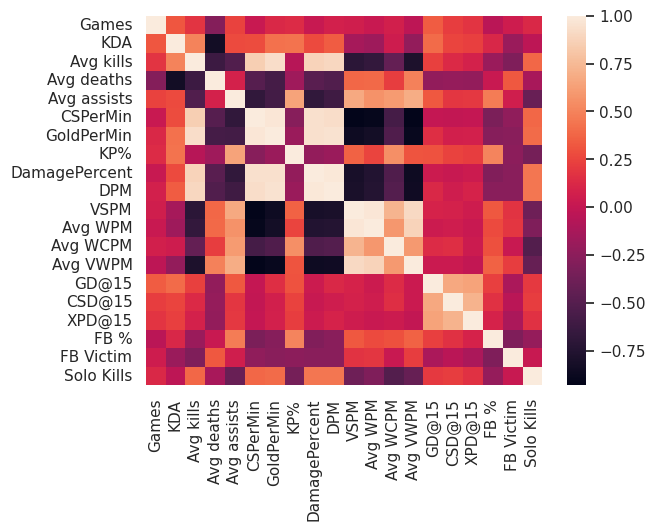

In [14]:
sns.heatmap(df_corr)

### Analysis of Categorical Features

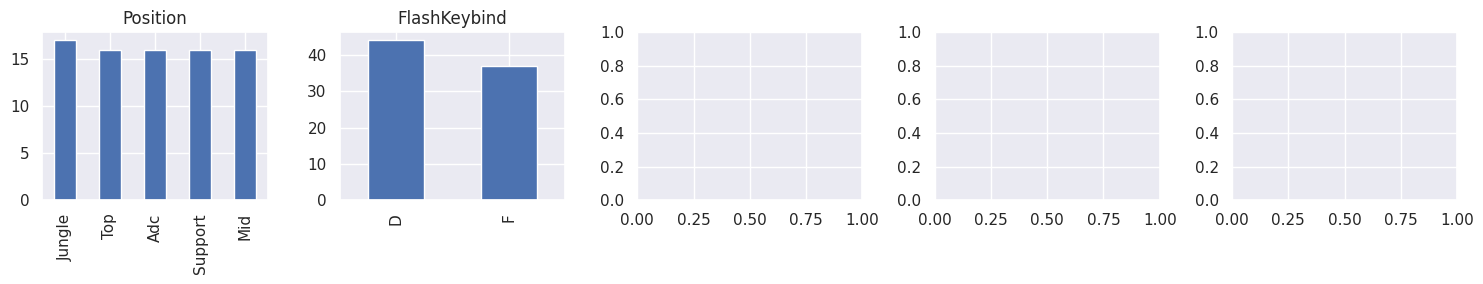

In [15]:
cat_cols = df.select_dtypes(include=["object"]).columns
num_plots = len(cat_cols)
num_rows = math.ceil(num_plots / 5.0)

fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols):
    ax = axs[i]
    df[col].value_counts().plot(
        kind='bar',
        ax=ax,
        title=col,
        xlabel=''
    )
plt.tight_layout()

### Feature Importance Analysis

In [16]:
df_X = df.drop(columns=[target_name])
df_y = df[target_name]

In [17]:
# numerical features
num_cols = df_X.select_dtypes(exclude=["object"]).columns
feature_importances = df[num_cols].corrwith(df[target_name]).abs()
feature_importances.sort_values(ascending=False)

,0
KDA,0.702797
Games,0.615902
GD@15,0.586332
Avg assists,0.492857
Avg deaths,0.489757
XPD@15,0.319637
CSD@15,0.315012
KP%,0.277924
Avg kills,0.252613
GoldPerMin,0.192944


In [18]:
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(df_X)
mi = mutual_info_regression(X_encoded, df_y)

mi_lst = list(zip(df_X.columns, mi))
sorted_mi_lst = sorted(mi_lst, key=lambda x: x[1], reverse=True)
sorted_mi_lst

[('Games', 1.5657044540076213),
 ('KDA', 0.4815833221042909),
 ('FB %', 0.24076331858493072),
 ('FB Victim', 0.22510696028813282),
 ('GD@15', 0.220317091653758),
 ('Avg assists', 0.21911121712384052),
 ('XPD@15', 0.15368222204614312),
 ('Avg deaths', 0.14991979418887214),
 ('FlashKeybind', 0.11040019506043963),
 ('Avg WPM', 0.06304890154817544),
 ('DPM', 0.04491085550966467),
 ('KP%', 0.04428638225989934),
 ('CSD@15', 0.04427948561202166),
 ('VSPM', 0.015555693970392692),
 ('Position', 0.0),
 ('Avg kills', 0.0),
 ('CSPerMin', 0.0),
 ('GoldPerMin', 0.0),
 ('DamagePercent', 0.0),
 ('Avg WCPM', 0.0),
 ('Avg VWPM', 0.0),
 ('Solo Kills', 0.0)]

### Data Preparation

In [19]:
seed = 1

In [20]:
# using only df_full_train and df_test due to small dataset size and planned cross-validation
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train[target_name].values
y_test = df_test[target_name].values

del df_full_train[target_name]
del df_test[target_name]

In [21]:
# encode features
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train.to_dict(orient="records")
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient="records")
X_test = dv.fit_transform(test_dict)

In [22]:
features = list(dv.get_feature_names_out())

## Parameter Tuning

In [23]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

def train_kfold(train_func, **kwargs):
    rmse_list = []
    for train_idx, val_idx in kfold.split(df_full_train):
        X_train = X_full_train[train_idx]
        X_val = X_full_train[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        y_pred = train_func(X_train, y_train, X_val, **kwargs)

        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_list.append(rmse)
    return rmse_list

In [24]:
def plot_rmse(df):
    plt.figure(figsize=(8, 5))

    plt.errorbar(df.index, df["rmse_mean"], yerr=2*df["rmse_std"],
                fmt='o', color='blue', ecolor='red', elinewidth=2, capsize=4, alpha=0.7)

    plt.xlabel("index")
    plt.ylabel("rmse mean +- 2*std")
    plt.grid(True)
    plt.show()

In [25]:
# store results of each model for later selection
model_results = {}

In [26]:
top_k_model_result = 10

def save_model_result(model_name, scores, param_names):
    columns = param_names + ["rmse_mean", "rmse_std"]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["rmse_upper"] = df_scores["rmse_mean"] + 2*df_scores["rmse_std"]
    df_sorted_scores = df_scores.sort_values(by="rmse_upper").reset_index(drop=True)
    df_sorted_scores_sub = df_sorted_scores.head(top_k_model_result).reset_index(drop=True)
    model_results[model_name] = df_sorted_scores_sub
    return df_sorted_scores_sub

### Linear Regression

In [27]:
def train_linear(X_train, y_train, X_val, **kwargs):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [28]:
def train_ridge(X_train, y_train, X_val, **kwargs):
    model = Ridge(**kwargs, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [29]:
scores = []
for alpha in tqdm([0, 0.01, 0.1, 0.5, 1, 10, 100]):
    if alpha == 0:
        rmse_list = train_kfold(train_func=train_linear)
    else:
        rmse_list = train_kfold(train_func=train_ridge, alpha=alpha)

    rmse_mean = np.mean(rmse_list)
    rmse_std = np.std(rmse_list)
    scores.append((alpha, rmse_mean, rmse_std))

  0%|          | 0/7 [00:00<?, ?it/s]

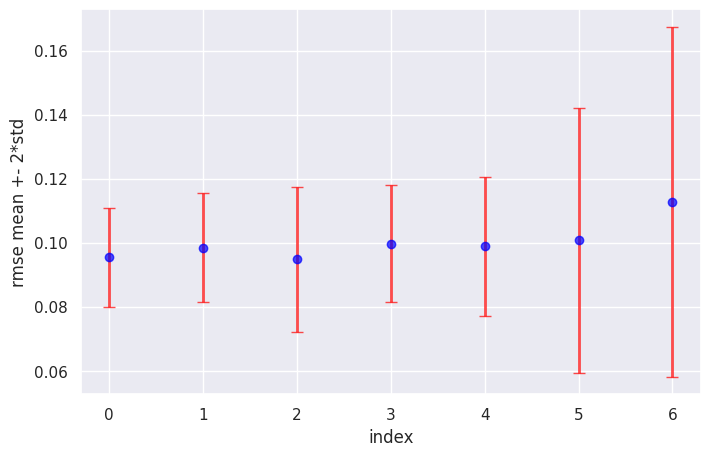

,alpha,rmse_mean,rmse_std,rmse_upper
0,0.10,0.095403,0.007754,0.110910
1,0.50,0.098392,0.008509,0.115411
2,0.01,0.094829,0.011305,0.117439
3,0.00,0.099709,0.009155,0.118020
4,1.00,0.098836,0.010923,0.120681
5,10.00,0.100718,0.020734,0.142185
6,100.00,0.112800,0.027335,0.167470


In [30]:
df_sorted_scores_sub = save_model_result("linear regression", scores, ["alpha"])
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

### Decision Tree

In [31]:
def train_decision_tree(X_train, y_train, X_val, **kwargs):
    model = DecisionTreeRegressor(**kwargs, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [32]:
scores = []
for max_depth in tqdm([1, 2, 3, 4, 5, 6, 10, 15, 20, None]):
    for min_samples_leaf in [1, 5, 10, 15, 20, 50, 100, 200]:
        rmse_list = train_kfold(train_func=train_decision_tree, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

        rmse_mean = np.mean(rmse_list)
        rmse_std = np.std(rmse_list)
        scores.append((max_depth, min_samples_leaf, rmse_mean, rmse_std))

  0%|          | 0/10 [00:00<?, ?it/s]

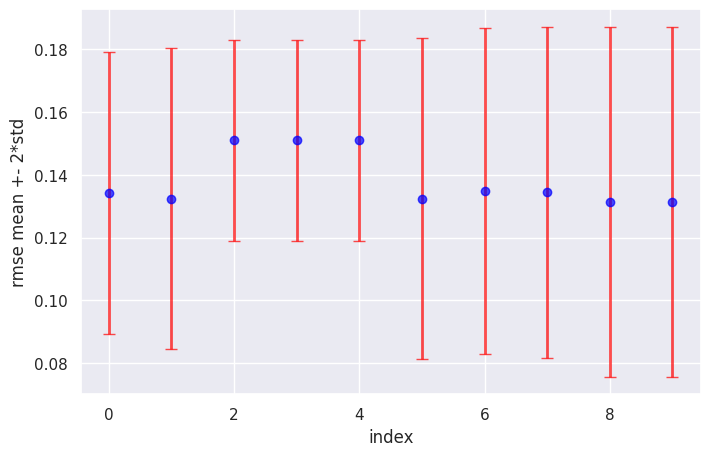

,max_depth,min_samples_leaf,rmse_mean,rmse_std,rmse_upper
0,5.0,1,0.134121,0.022483,0.179087
1,2.0,10,0.132412,0.023963,0.180338
2,1.0,1,0.151008,0.016004,0.183015
3,1.0,5,0.151008,0.016004,0.183015
4,1.0,10,0.151008,0.016004,0.183015
5,2.0,5,0.132428,0.025559,0.183547
6,6.0,1,0.134842,0.026005,0.186852
7,4.0,5,0.134388,0.026365,0.187117
8,4.0,10,0.131415,0.027859,0.187133
9,20.0,10,0.131415,0.027859,0.187133


In [33]:
df_sorted_scores_sub = save_model_result("decision tree", scores, ["max_depth", "min_samples_leaf"])
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

### Random Forest

In [34]:
def train_random_forest(X_train, y_train, X_val, **kwargs):
    model = RandomForestRegressor(**kwargs, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [35]:
scores = []
for n_estimators in tqdm([10, 30, 50, 100, 150, 200]):
    for max_depth, min_samples_leaf in model_results["decision tree"][["max_depth", "min_samples_leaf"]].values:
        max_depth = None if pd.isna(max_depth) else int(max_depth)
        min_samples_leaf = int(min_samples_leaf)

        rmse_list = train_kfold(train_func=train_random_forest, n_estimators=n_estimators,
                                max_depth=max_depth, min_samples_leaf=min_samples_leaf)

        rmse_mean = np.mean(rmse_list)
        rmse_std = np.std(rmse_list)
        scores.append((n_estimators, max_depth, min_samples_leaf, rmse_mean, rmse_std))

  0%|          | 0/6 [00:00<?, ?it/s]

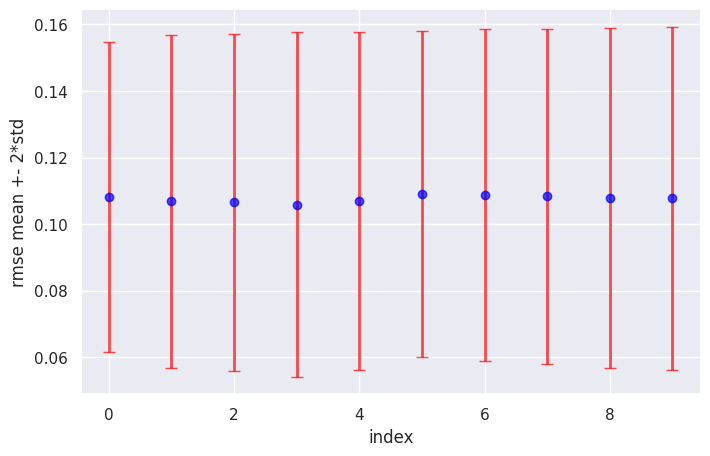

,n_estimators,max_depth,min_samples_leaf,rmse_mean,rmse_std,rmse_upper
0,10,5,1,0.108063,0.023272,0.154606
1,200,5,1,0.106890,0.025024,0.156939
2,30,6,1,0.106563,0.025352,0.157266
3,200,6,1,0.105877,0.025862,0.157601
4,30,5,1,0.106995,0.025373,0.157741
5,100,5,1,0.109197,0.024489,0.158175
6,100,6,1,0.108722,0.024934,0.158591
7,150,5,1,0.108365,0.025210,0.158785
8,150,6,1,0.107864,0.025555,0.158975
9,50,6,1,0.107721,0.025797,0.159315


In [36]:
df_sorted_scores_sub = save_model_result("random forest", scores, ["n_estimators", "max_depth", "min_samples_leaf"])
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

### XGBoost

In [37]:
def train_xgboost(X_train, y_train, X_val, **kwargs):
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, feature_names=features)

    params = {
        "seed": seed,
        "objective": 'reg:squarederror',
        "nthread": 8,
        "verbosity": 1,
    } | kwargs
    model = xgb.train(params, dtrain, num_boost_round=200)
    y_pred = model.predict(dval)
    return y_pred

In [38]:
scores = []
for eta in tqdm([0.01, 0.1, 0.3, 0.5, 0.9]):
    for max_depth, min_samples_leaf in model_results["decision tree"][["max_depth", "min_samples_leaf"]].values:
        max_depth = None if pd.isna(max_depth) else int(max_depth)
        min_samples_leaf = int(min_samples_leaf)

        rmse_list = train_kfold(train_func=train_xgboost, eta=eta,
                                max_depth=max_depth, min_child_weight=min_samples_leaf)

        rmse_mean = np.mean(rmse_list)
        rmse_std = np.std(rmse_list)
        scores.append((eta, max_depth, min_samples_leaf, rmse_mean, rmse_std))

  0%|          | 0/5 [00:00<?, ?it/s]

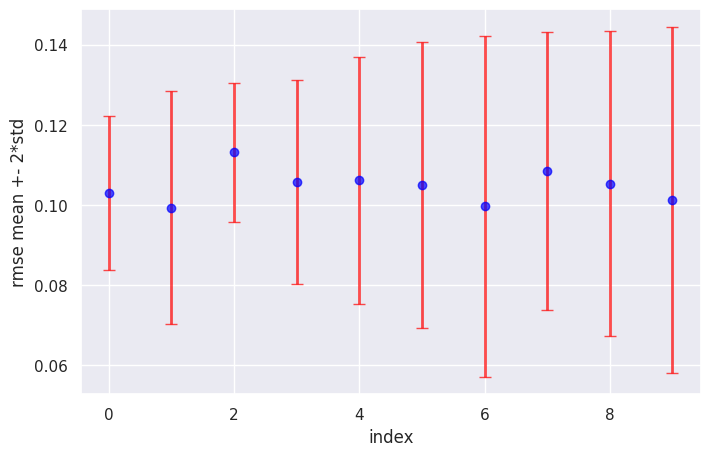

,eta,max_depth,min_child_weight,rmse_mean,rmse_std,rmse_upper
0,0.3,1,5,0.103061,0.009614,0.122289
1,0.1,1,5,0.099360,0.014574,0.128509
2,0.5,1,5,0.113131,0.008660,0.130450
3,0.3,2,5,0.105715,0.012726,0.131166
4,0.3,4,5,0.106124,0.015416,0.136955
5,0.1,2,5,0.105001,0.017849,0.140699
6,0.1,1,1,0.099663,0.021244,0.142152
7,0.1,2,10,0.108594,0.017338,0.143270
8,0.1,1,10,0.105295,0.019035,0.143365
9,0.1,4,5,0.101279,0.021588,0.144455


In [39]:
df_sorted_scores_sub = save_model_result("xgboost", scores, ["eta", "max_depth", "min_child_weight"])
plot_rmse(df_sorted_scores_sub)
df_sorted_scores_sub

## Model Selection

In [40]:
min_rmse_upper = float("inf")
best_model_name = None
best_model_df = None

for model_name, df in model_results.items():
    min_rmse_for_model = df.loc[0, "rmse_upper"]
    if min_rmse_for_model < min_rmse_upper:
        min_rmse_upper = min_rmse_for_model
        best_model_name = model_name
        best_model_df = df.iloc[0]

best_model_name, best_model_df

('linear regression',
 alpha         0.100000
 rmse_mean     0.095403
 rmse_std      0.007754
 rmse_upper    0.110910
 Name: 0, dtype: float64)

In [41]:
df_params = best_model_df[best_model_df.index[:-3]]
param_dict = df_params.to_dict()
param_dict

{'alpha': 0.1}

In [42]:
# save best model parameters for use in the training script
best_model_params = {
    "model_name": best_model_name,
    "params": param_dict,
}
json_object = json.dumps(best_model_params, indent=4)

with open("best_model_params.json", "w") as outfile:
    outfile.write(json_object)

In [43]:
if best_model_name == "linear regression":
    if param_dict["alpha"] == 0:
        model = LinearRegression()
    else:
        model = Ridge(**param_dict, random_state=seed)
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
elif best_model_name == "decision tree":
    model = DecisionTreeRegressor(**param_dict, random_state=seed)
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
elif best_model_name == "random forest":
    model = RandomForestRegressor(**param_dict, random_state=seed, n_jobs=-1)
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
elif best_model_name == "xgboost":
    dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=features)
    dtest = xgb.DMatrix(X_test, feature_names=features)

    params = {
        "seed": seed,
        "objective": 'reg:squarederror',
        "nthread": 8,
        "verbosity": 1,
    } | param_dict
    model = xgb.train(params, dfulltrain, num_boost_round=200)
    y_pred = model.predict(y_test)

In [44]:
root_mean_squared_error(y_test, y_pred)

0.1450606188503998